In [1]:
# Useful if on a multiGPU machine to only use on GPU
# otherwise you can comment this out 

import os 

dev = '0'

os.environ["OMP_NUM_THREADS"] = str(1)
os.system("OMP_NUM_THREADS=1")
os.system("CUDA_VISIBLE_DEVICES=" + dev)
os.environ["CUDA_VISIBLE_DEVICES"] = dev
os.system("echo $CUDA_VISIBLE_DEVICES")

os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=1'

0


In [2]:
import jax
import numpy as np
import lalsimulation as LS 
import lal 
import matplotlib.pyplot as plt

from ripplegw.waveforms import IMRPhenomPv2_NRTidal, IMRPhenomD_NRTidalv2
from ripplegw.waveforms.IMRPhenom_tidal_utils import get_kappa

# check GPU is being used
from jax.lib import xla_bridge

print(xla_bridge.get_backend().platform)

# enbale 64 bit precision
# jax.config.update("jax_enable_x64", True)

%load_ext autoreload
%autoreload 2

/work/nihargupte/environments/micromamba/envs/dingo-devel-bns/lib/python3.9/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


gpu


In [3]:
# comparing the lal IMRPhenomPv2_NRTidal to my jaxxed implementation 
# use LALSimIMRPhenomP.c ln 949
# XLALSimNRTunedTidesFDTidalPhaseFrequencySeries
# LALSimNRTunedTides.c ln 364
# input parameters

fs = np.arange(20.0, 1024.0, 0.125, dtype=np.float32)
m1 = 40.0
m2 = 25.0
lambda1 = 100
lambda2 = 10

# intermediate variables
total_mass = m1 + m2
q = m1 / m2
m1_SI, m2_SI = m1 * lal.MSUN_SI, m2 * lal.MSUN_SI

# defining output arrays
phi_array = lal.CreateREAL8Vector(len(fs))
amp_array = lal.CreateREAL8Vector(len(fs))
planck_taper_array = lal.CreateREAL8Vector(len(fs))
frequency_array = lal.CreateREAL8Vector(len(fs))
frequency_array.data = fs
nr_tidal_version = LS.NRTidal_V

In [4]:
# Testing kappa2T 
jax_kappa2T = get_kappa([m1, m2, 0, 0, lambda1, lambda2])
kappa2T = LS.SimNRTunedTidesComputeKappa2T(m1_SI, m2_SI, lambda1, lambda2)

jax_fHz_mrg = IMRPhenomD_NRTidalv2._get_merger_frequency([m1, m2, 0, 0, 0, 0], jax_kappa2T)
fHz_mrg = LS.SimNRTunedTidesMergerFrequency(total_mass, kappa2T, q)

assert np.allclose(jax_kappa2T, kappa2T)
assert np.allclose(jax_fHz_mrg, fHz_mrg)

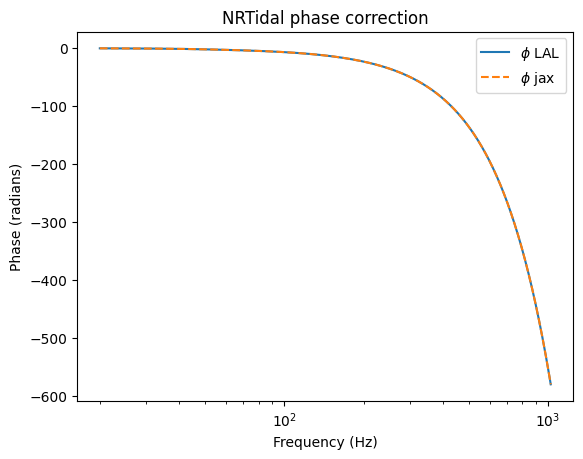

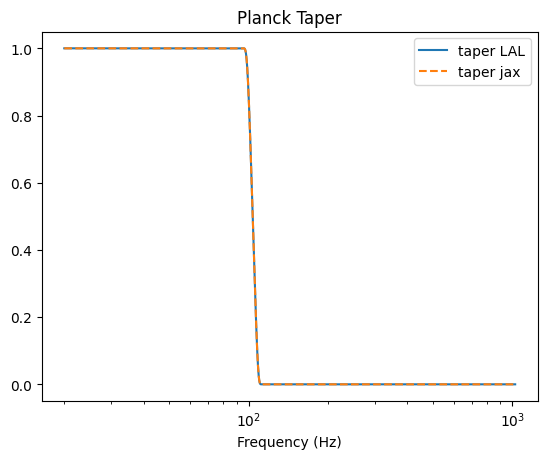

In [5]:
# generating the frequency series
LS.SimNRTunedTidesFDTidalPhaseFrequencySeries(phi_array, amp_array, planck_taper_array, fs, m1_SI, m2_SI, lambda1, lambda2, nr_tidal_version)

# generating the frequency series from my implementation
jax_phi_array, jax_planck_taper_array = IMRPhenomPv2_NRTidal.get_nr_tuned_tidal_phase_taper(fs, m1, m2, lambda1, lambda2)

# plotting the phase as a function of the frequency
plt.title("NRTidal phase correction")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (radians)")
plt.xscale("log")
plt.plot(fs, phi_array.data, label=r"$\phi$ LAL")
plt.plot(fs, jax_phi_array, label=r"$\phi$ jax", linestyle='--')
plt.legend()
plt.show()

plt.title("Planck Taper")
plt.xlabel("Frequency (Hz)")
plt.xscale("log")
plt.plot(fs, planck_taper_array.data, label=r"taper LAL")
plt.plot(fs, jax_planck_taper_array, label="taper jax", linestyle='--')
plt.legend()

In [6]:
from bilby.gw.utils import (
    lalsim_SimInspiralWaveformParamsInsertTidalLambda1,
    lalsim_SimInspiralWaveformParamsInsertTidalLambda2,
)
from bilby.gw.conversion import bilby_to_lalsimulation_spins

# Testing a particular set of parameters 
p = {
    "mass_1": 29.0,
    "mass_2": 25.0,
    "theta_jn": 2.0,
    "s1x": -0.12887890368373683,
    "s1y":  0.12830861468564897,
    "s1z": -0.08322936730942848,
    "s2x": -0.06303814510757753,
    "s2y": -0.17058447959491577,
    "s2z": -0.08322936730942848, 
    "phase": 1.9551410012274015,
    "f_ref": 20.,
    "luminosity_distance": 100.,
    "geocent_time": 0.0,
    "ra": 0.,
    "dec": 0.,
    "lambda_1": 100.0,
    "lambda_2": 1000.0
}

lal_parameter_tuple = (
    p["phase"],
    p["mass_1"] * lal.MSUN_SI, 
    p["mass_2"] * lal.MSUN_SI, 
    p["s1x"], 
    p["s1y"],
    p["s1z"],
    p["s2x"],
    p["s2y"],
    p["s2z"],
    p["f_ref"], 
    p["luminosity_distance"] * 1e6 * lal.PC_SI,
    p["theta_jn"]
)
lal_parameter_tuple = tuple(float(p) for p in lal_parameter_tuple)

# inserting tidal parameters
lal_params = lal.CreateDict()
# lalsim_SimInspiralWaveformParamsInsertTidalLambda1(lal_params, p.get("lambda_1", 0))
# lalsim_SimInspiralWaveformParamsInsertTidalLambda2(lal_params, p.get("lambda_2", 0))

# create lal object for frequency array
fs = np.linspace(20.0, 512.0, 1969, dtype=np.float32)
frequency_array = lal.CreateREAL8Vector(len(fs))
frequency_array.data = fs

lal_parameters = [
    *lal_parameter_tuple,
    lal_params,
    80, # IMRPhenomPv2_NRTidal
    frequency_array
]


test_array = np.array(
    [
        p["mass_1"], 
        p["mass_2"],
        p["s1x"], 
        p["s1y"],
        p["s1z"],
        p["s2x"],
        p["s2y"],
        p["s2z"],
        p["luminosity_distance"], 
        p["geocent_time"], 
        p["phase"],
        p["theta_jn"], 
        p["lambda_1"], 
        p["lambda_2"]
    ],
    dtype=np.float32 
)

lal_parameters

[1.9551410012274015,
 5.766388625024347e+31,
 4.971024676745127e+31,
 -0.12887890368373683,
 0.12830861468564897,
 -0.08322936730942848,
 -0.06303814510757753,
 -0.17058447959491577,
 -0.08322936730942848,
 20.0,
 3.085677581491367e+24,
 2.0,
 <Swig Object of type 'tagLALDict *' at 0x7f364853e8b0>,
 80,
 <Swig Object of type 'tagREAL8Vector *' at 0x7f35485e1670>]

In [7]:
test_array = np.array([ 2.9000000e+01,  2.5000000e+01, -1.2887891e-01,
        1.2830861e-01, -8.3229370e-02, -6.3038148e-02,
       -1.7058448e-01, -8.3229370e-02,  1.0000000e+02,
        0.0000000e+00,  2.0000000e+00,  2.0000000e+00,
        1.0000000e+02,  1.0000000e+03])

/work/nihargupte/src/ripple/src/ripplegw/waveforms/IMRPhenomD_NRTidalv2.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  1.0 - 1.0 / (jnp.exp((yp - y) / (x - y) + (yp - y) / (x - yp)) + 1.0),
/work/nihargupte/src/ripple/src/ripplegw/waveforms/IMRPhenomD_NRTidalv2.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  jnp.exp((yp - y) / (x - y) + (yp - y) / (x - yp))
/work/nihargupte/src/ripple/src/ripplegw/waveforms/IMRPhenomD_NRTidalv2.py:70: RuntimeWarning: divide by zero encountered in scalar divide
  (-1.0 + a) / (x - y)
/work/nihargupte/src/ripple/src/ripplegw/waveforms/IMRPhenomD_NRTidalv2.py:72: RuntimeWarning: divide by zero encountered in scalar divide
  + (-y + yp) / ((x - y) ** 2)
/work/nihargupte/src/ripple/src/ripplegw/waveforms/IMRPhenomD_NRTidalv2.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  / ((jnp.exp((yp - y) / (x - y) + (yp - y) / (x - yp)) + 1.0) ** 2),


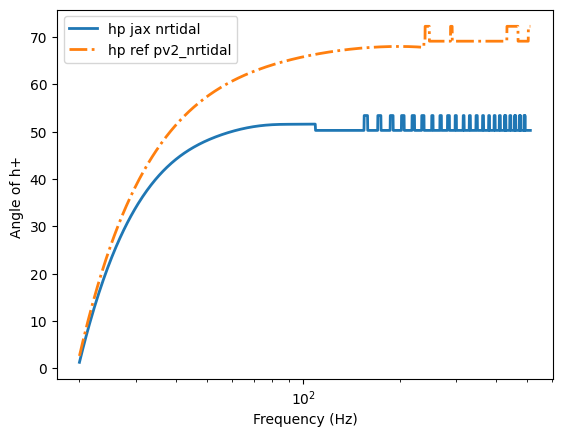

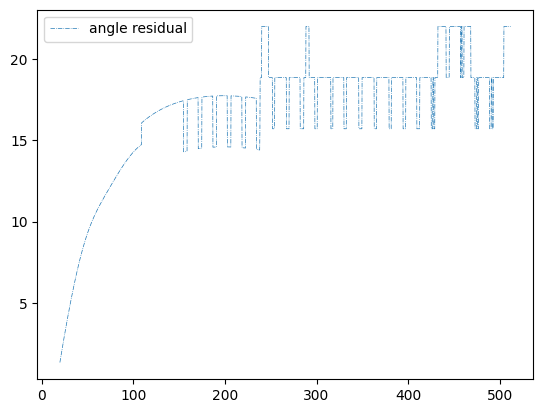

/work/nihargupte/environments/micromamba/envs/dingo-devel-bns/lib/python3.9/site-packages/jax/_src/array.py:394: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype, **kwds)
/work/nihargupte/environments/micromamba/envs/dingo-devel-bns/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


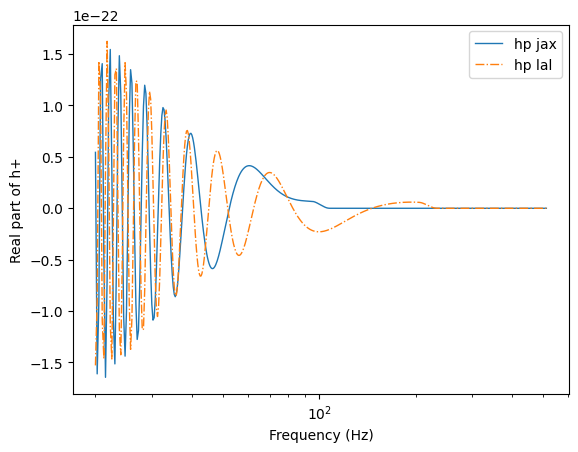

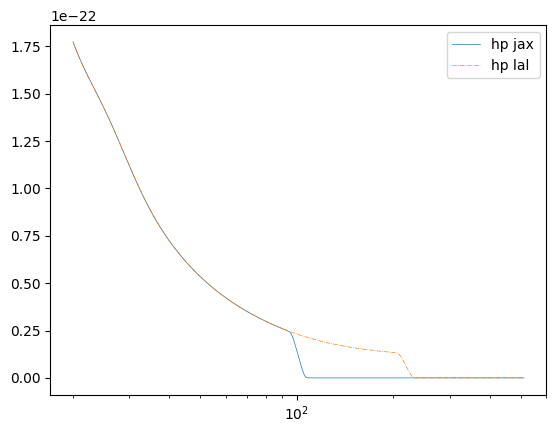

In [8]:
# generating jax version waveforms
f_ref = p["f_ref"]
hp, hc = IMRPhenomPv2_NRTidal.gen_IMRPhenomPv2_NRTidal(fs, test_array, f_ref)

# generating reference waveforms 
# lal will flip the lambdas if m_1 > m_2 and do it *in place* so we need to reset it each time 
# lal_params = lal.CreateDict()
# lalsim_SimInspiralWaveformParamsInsertTidalLambda1(lal_params, p.get("lambda_1", 0))
# lalsim_SimInspiralWaveformParamsInsertTidalLambda2(lal_params, p.get("lambda_2", 0))
# lal_parameters[-3] = lal_params
ref_hp, ref_hc = LS.SimInspiralChooseFDWaveformSequence(*lal_parameters)

plt.xscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Angle of h+ ")
plt.plot(fs, np.unwrap(np.angle(hp)), linewidth=2, label="hp jax nrtidal")
plt.plot(fs, np.unwrap(np.angle(ref_hp.data.data)), linewidth=2, linestyle='-.', label="hp ref pv2_nrtidal")
plt.legend()
plt.show()

plt.plot(fs, np.unwrap(np.angle(ref_hp.data.data)) - np.unwrap(np.angle(hp)), linewidth=0.5, linestyle='-.', label="angle residual")
plt.legend()
plt.show()

plt.xscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Real part of h+")
plt.plot(fs, hp, linewidth=1.0, label="hp jax")
plt.plot(fs, ref_hp.data.data, linewidth=1.0, linestyle='-.', label="hp lal")
plt.legend()
plt.show()

plt.xscale("log")
plt.plot(fs, np.abs(hp), linewidth=0.5, label="hp jax")
plt.plot(fs, np.abs(ref_hp.data.data), linewidth=0.5, linestyle='-.', label="hp lal")
plt.legend()
plt.show()